In [1]:
from pyiron_ising import Project
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyiron_base import DataContainer
from abc import ABC, abstractproperty, abstractmethod
sns.set_context('notebook')

def _optimal_score(n_tot, n_border, border_score):
    n_interior = n_tot - n_border
    return (n_interior + border_score * n_border) / n_tot

In [2]:
pr = Project('scaling_1d')
# pr.remove_jobs(recursive=True)

In [3]:
class SizeConvergence(ABC):
    def __init__(
        self, 
        name, 
        mutations, 
        max_steps, 
        size_reps, 
        stats_reps, 
        queue=None, 
        delete_existing_job=False
    ):
        self.name = name
        self.mutations = mutations if hasattr(mutations, '__len__') else [mutations]
        self.max_steps = max_steps
        self.size_reps = size_reps
        self.stats_reps = stats_reps
        self.queue = queue
        self.delete_existing_job = delete_existing_job
        
        self.output = DataContainer()
        
    @abstractproperty
    def model(self):
        pass
    
    @abstractmethod
    def stopping_fitness(self, repetitions):
        pass
        
    def run(self):
        size_jobs = []
        for r in self.size_reps:
            stats_jobs = []
            for n in range(self.stats_reps):
                job = pr.ising.job.Ising(
                    job_name=f'{self.name}_r{r}_n{n}', 
                    delete_existing_job=self.delete_existing_job,
                )
                job.input.model = self.model(n_spins=2, repetitions=r)
                for m in self.mutations:
                    job.input.mutations.append(m)
                job.input.n_print = self.max_steps
                job.input.n_steps = self.max_steps
                job.input.log_mutations = False
                job.input.stopping_fitness = self.stopping_fitness(r)
                if self.queue is not None:
                    job.server.queue = self.queue
                stats_jobs.append(job)
                job.run()
            size_jobs.append(stats_jobs)
        self.output.jobs = size_jobs
        self.output.size = np.array([len(jobs[0].model) for jobs in size_jobs])
        self.collect_output()
    
    def collect_output(self):   
        if not np.all([[njob.status == 'finished' for njob in njobs] for njobs in self.output.jobs]):
            print("Some jobs unfinished")
            self.output.frames = None
            self.output.median = None
            self.output.worst = None
        else:
            print("Collecting generation data")
            final_frames = np.array(
                [[njob.output.frame[-1] for njob in njobs] for njobs in self.output.jobs]
            )
            self.output.frames = final_frames
            self.output.median = np.median(final_frames, axis=-1)
            self.output.worst = final_frames.max(axis=-1)
            
class ChainConvergence(SizeConvergence):
    def __init__(
        self, 
        name, 
        mutations, 
        max_steps=1E9, 
        size_reps=None, 
        stats_reps=10, 
        queue=None, 
        delete_existing_job=False
    ):
        super().__init__(
            name='chain_' + name, 
            mutations=mutations, 
            max_steps=max_steps, 
            size_reps=[64 * n for n in range(1, 5)] if size_reps is None else size_reps, 
            stats_reps=stats_reps, 
            queue=queue, 
            delete_existing_job=delete_existing_job
        )
        
    @property
    def model(self):
        return pr.ising.model.Chain1D
    
    def stopping_fitness(self, repetitions):
        return _optimal_score(repetitions, 4, (1 - 1) / 2)

In [4]:
CHAIN_QUEUE = 'cm'
REPS_SHORT = [64 * n for n in range(1, 9)]
REPS_LONG = REPS_SHORT + [256*n for n in range(3, 5)]
STATS = 100

In [5]:
chain_rls = ChainConvergence(
    name='rls', 
    mutations=pr.ising.mutation.Swap(naive=False),
    size_reps=REPS_SHORT,
    stats_reps=STATS,
    queue=CHAIN_QUEUE, 
)

In [6]:
chain_boundary = ChainConvergence(
    name='boundary', 
    mutations=pr.ising.mutation.Swap(naive=False, imperfect_seeds_only=True),
    size_reps=REPS_LONG,
    stats_reps=STATS,
    queue=CHAIN_QUEUE,
)

In [7]:
chain_cluster = ChainConvergence(
    name='cluster', 
    mutations=pr.ising.mutation.Cluster(),
    size_reps=REPS_LONG,
    stats_reps=STATS,
    queue=CHAIN_QUEUE,
)

In [8]:
chain_cb = ChainConvergence(
    name='cb', 
    mutations=pr.ising.mutation.Cluster(imperfect_seeds_only=True),
    size_reps=REPS_LONG,
    stats_reps=STATS,
    queue=CHAIN_QUEUE,
)

In [9]:
chain_rls.run()

2022-01-28 17:51:42,766 - pyiron_log - WARNING - The job chain_rls_r64_n0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:51:43,073 - pyiron_log - WARNING - The job chain_rls_r64_n1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:51:43,379 - pyiron_log - WARNING - The job chain_rls_r64_n2 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:51:43,677 - pyiron_log - WARNING - The job chain_rls_r64_n3 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:51:43,976 - pyiron_log - WARNING - The job chain_rls_r64_n4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:51:44,276 - pyiron_log - WARNING - The job chain_rls_r64_n5 is being loaded instead of running. 

In [10]:
chain_boundary.run()

2022-01-28 17:57:16,999 - pyiron_log - WARNING - The job chain_boundary_r64_n0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:57:17,297 - pyiron_log - WARNING - The job chain_boundary_r64_n1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:57:17,597 - pyiron_log - WARNING - The job chain_boundary_r64_n2 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:57:17,895 - pyiron_log - WARNING - The job chain_boundary_r64_n3 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:57:18,195 - pyiron_log - WARNING - The job chain_boundary_r64_n4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 17:57:18,506 - pyiron_log - WARNING - The job chain_boundary_r64_n5 is bei

In [11]:
chain_cluster.run()

2022-01-28 18:02:55,306 - pyiron_log - WARNING - The job chain_cluster_r64_n0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:02:55,621 - pyiron_log - WARNING - The job chain_cluster_r64_n1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:02:55,940 - pyiron_log - WARNING - The job chain_cluster_r64_n2 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:02:56,253 - pyiron_log - WARNING - The job chain_cluster_r64_n3 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:02:56,570 - pyiron_log - WARNING - The job chain_cluster_r64_n4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:02:56,879 - pyiron_log - WARNING - The job chain_cluster_r64_n5 is being loa

In [12]:
chain_cb.run()

2022-01-28 18:08:35,013 - pyiron_log - WARNING - The job chain_cb_r64_n0 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:08:35,325 - pyiron_log - WARNING - The job chain_cb_r64_n1 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:08:35,633 - pyiron_log - WARNING - The job chain_cb_r64_n2 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:08:35,935 - pyiron_log - WARNING - The job chain_cb_r64_n3 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:08:36,238 - pyiron_log - WARNING - The job chain_cb_r64_n4 is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'
2022-01-28 18:08:36,542 - pyiron_log - WARNING - The job chain_cb_r64_n5 is being loaded instead of running. To re-

In [ ]:
pr.job_table()[pr.job_table().status == 'running']

In [70]:
colors = sns.color_palette(n_colors=6)

results = {
    'Swap': {
        'data': chain_rls,
        'scale': lambda n: n**4,
        'scale_label': 'n^4',
        'marker': '^',
        'linestyle': '-',
        'color': colors[0]
    },
    # 'RLS (empirical)': {
    #     'data': chain_rls,
    #     'scale': lambda n: 100 * n**3 * np.log(n),
    #     'scale_label': 'n^3 \log n',
    #     'marker': 'v',
    #     'linestyle': '--',
    #     'color': colors[1]
    # },
    'Boundary': {
        'data': chain_boundary,
        'scale': lambda n: n**2 * np.log(n),
        'scale_label': 'n^2 \log n',
        'marker': 'o',
        'linestyle': '-',
        'color': colors[2]
    },
    'Cluster': {
        'data': chain_cluster,
        'scale': lambda n: n**(4/3),
        'scale_label': 'n^{4/3}',
        'marker': 's',
        'linestyle': '-',
        'color': colors[3]
    },
    'Cluster (empirical)': {
        'data': chain_cluster,
        'scale': lambda n: n,
        'scale_label': 'n',
        'marker': 'd',
        'linestyle': '--',
        'color': colors[4]
    },
    'BCluster': {
        'data': chain_cb,
        'scale': lambda n: n,
        'scale_label': 'n',
        'marker': 'h',
        'linestyle': '-',
        'color': colors[5]
    },
    # 'Cluster and boundary (empirical)': {
    #     'data': chain_cb,
    #     'scale': lambda n: np.log(n),
    #     'scale_label': '\log n',
    #     'marker': 'H'
    # }
}

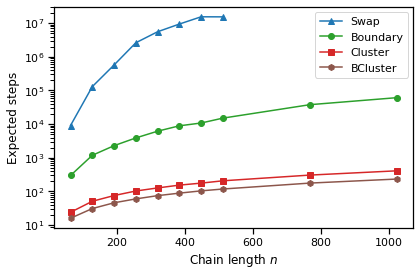

In [71]:
fig, ax = plt.subplots()

for k, v in results.items():
    size = v['data'].output.size
    worst = v['data'].output.median
    
    if 'empirical' not in k:
        ax.plot(
            size,
            worst,
            marker=v['marker'],
            color=v['color'],
            label=k
        )

ax.set_yscale('log')
ax.set_ylabel('Expected steps')
ax.legend()
ax.set_xlabel('Chain length $n$')
plt.tight_layout()
plt.savefig('../figs/chain_convergence.eps', format='eps')
plt.show()

Swap 4476.43 15351416
Boundary 110.1 61056
Cluster 22.43 410
Cluster (empirical) 2.49 410
BCluster 4.35 233


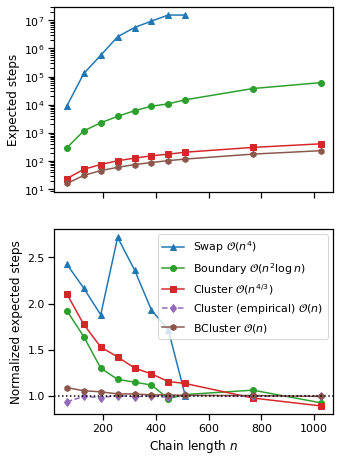

In [72]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(5, 7.5))

for k, v in results.items():
    size = v['data'].output.size
    worst = v['data'].output.median
    order = worst / v['scale'](size)
    prefactor = np.mean(order[np.argwhere(size>=512)])
    scaled = order / prefactor
    print(k, round(1/prefactor, 2), int(worst[-1]))
    
    if 'empirical' not in k:
        axes[0].plot(
            size,
            worst,
            marker=v['marker'],
            color=v['color']
        )
    axes[1].plot(
        size, 
        scaled, 
        label=f"{k} $\mathcal{{O}}({v['scale_label']})$",
        marker=v['marker'],
        linestyle=v['linestyle'],
        color=v['color']
    )

    
axes[0].annotate('(a)', (50,1E8), xytext=(-175, 5E8))
axes[0].set_yscale('log')
axes[0].set_ylabel('Expected steps')
axes[1].annotate('(b)', (50,3), xytext=(-175, 3.))
axes[1].axhline(1, linestyle=':', color='k')
axes[1].legend()
axes[1].set_xlabel('Chain length $n$')
axes[1].set_ylabel('Normalized expected steps')
# plt.tight_layout()
plt.savefig('../figs/chain_scaling.eps', format='eps')
plt.show()